In [32]:
import pandas as pd
from datetime import datetime

In [33]:
google = pd.read_csv("google_final.csv")
google['reviewTime'] = pd.to_datetime(google['reviewTime'],format = '%b %d, %Y')
google = google[google['categories'].str.contains("Restaurant", na=False)]

In [34]:
btracts = pd.read_csv("business_to_tract.csv")
google = pd.merge(google,btracts,on="gPlusPlaceId",how="left")
google =google[google['index_right'].isna()==False]
google = pd.merge(google,google.groupby('index_right').agg({'gPlusPlaceId':'count'}).rename(columns={'gPlusPlaceId':'competition'}),on='index_right')
google = pd.merge(google,google.groupby('gPlusPlaceId').agg({'reviewTime':'max'}).rename(columns={'reviewTime':'lastReview'}),on='gPlusPlaceId')
google = pd.merge(google,google.groupby('gPlusPlaceId').agg({'reviewTime':'min'}).rename(columns={'reviewTime':'firstReview'}),on='gPlusPlaceId')

In [35]:
google = google.rename(columns={'index_right':'CT_index'})
google=google[(google['reviewTime']<"2013-01-01")]
google= google.groupby('gPlusPlaceId').agg({'rating':['mean','count'], 'closed':'first','lastReview':'first','firstReview':'first','CT_index':'first','competition':'first',})
google.columns = ["_".join(x) for x in google.columns.ravel()]
google['closed_label']=(google['closed_first']) & (google['lastReview_first']<"2013-06-01")
google['age'] = (google['lastReview_first']- google['firstReview_first']).dt.days

In [36]:
google['closed_label']=(google['closed_first']) & (google['lastReview_first']<"2013-06-01")
google = google.rename(columns={'CT_index_first':'CT'})

In [37]:
taxi = pd.read_csv("taxi_2012_final.csv")

In [38]:
google = pd.merge(google, taxi, on='CT')

In [39]:
# google_2011 =google[(google['reviewTime']>="2011-01-01") & (google['reviewTime']<"2012-01-01")]
# google_2011 = google_2011.groupby('gPlusPlaceId').agg({'rating':['mean','count'], 'closed':'first','lastReview':'first','CT_index':'first','competition':'first'})
# google_2011.columns = ["_".join(x) for x in google_2011.columns.ravel()]
# google_2011['closed_label']=(google_2011['closed_first']) & (google_2011['lastReview_first']<"2012-06-01")

In [40]:
# google_2012 =google[(google['reviewTime']>="2012-01-01") & (google['reviewTime']<"2013-01-01")]
# google_2012 = google_2012.groupby('gPlusPlaceId').agg({'rating':['mean','count'], 'closed':'first','lastReview':'first','CT_index':'first','competition':'first'})
# google_2012.columns = ["_".join(x) for x in google_2012.columns.ravel()]
# google_2012['closed_label']=(google_2012['closed_first']) & (google_2012['lastReview_first']<"2013-06-01")

In [41]:
# google_2013 =google[(google['reviewTime']>="2013-01-01") & (google['reviewTime']<"2014-01-01")]
# google_2013 = google_2013.groupby('gPlusPlaceId').agg({'rating':['mean','count'], 'closed':'first','lastReview':'first','CT_index':'first','competition':'first'})
# google_2013.columns = ["_".join(x) for x in google_2013.columns.ravel()]
# google_2013['closed_label']=(google_2013['closed_first']) & (google_2013['lastReview_first']<"2014-06-01")

In [42]:
# google_2014 =google[(google['reviewTime']>="2014-01-01") & (google['reviewTime']<"2015-01-01")]
# google_2014 = google_2014.groupby('gPlusPlaceId').agg({'rating':['mean','count'], 'closed':'first','lastReview':'first','CT_index':'first','competition':'first'})
# google_2014.columns = ["_".join(x) for x in google_2014.columns.ravel()]
# google_2014['closed_label']=(google_2014['closed_first']) & (google_2014['lastReview_first']<"2015-06-01")

In [43]:
# google_2011.to_csv("google_2011_features.csv")
# google_2012.to_csv("google_2012_features.csv")
# google_2013.to_csv("google_2013_features.csv")
# google_2014.to_csv("google_2014_features.csv")

In [44]:
google.head(3)

,rating_mean,rating_count,closed_first,lastReview_first,firstReview_first,CT,competition_first,closed_label,age,index_right,count_dropoffs,passenger_count
0,4.190476,42,False,2014-03-16,2005-03-30,1879.0,1891,False,3273,1879.0,1064484,1831910
1,4.000000,2,True,2012-02-27,2011-11-12,1879.0,1891,True,107,1879.0,1064484,1831910
2,4.200000,10,False,2014-02-23,2010-09-14,1879.0,1891,False,1258,1879.0,1064484,1831910


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

x_cols = ['rating_mean', 'rating_count', 'competition_first','count_dropoffs', 'passenger_count','age']
y_cols = ['closed_label']

X_train, X_test, y_train, y_test = train_test_split(google[x_cols], google['closed_label'], test_size=0.2)
LR= LogisticRegression()
LR.fit(X_train,y_train)
print("Accuracy: ",LR.score(X_test,y_test))




Accuracy:  0.8821603927986906


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [46]:
predictions = LR.predict(X_test)
# print(np.sum(predictions==True))
preds = y_test.to_frame()
preds['prediction'] = predictions
correct = preds[(preds['closed_label']==True)&(preds['closed_label']==preds['prediction'])].shape[0]
total = (preds[preds['closed_label']==True]).shape[0]
y_score = LR.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
print(average_precision)
print(correct)
print(total)

0.3856396383109631
52
175


In [61]:
lr_probs = LR.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.781


In [93]:
# calculate roc curves
confusion_matrix(y_test,predictions)

array([[1565,   93],
       [ 123,   52]], dtype=int64)

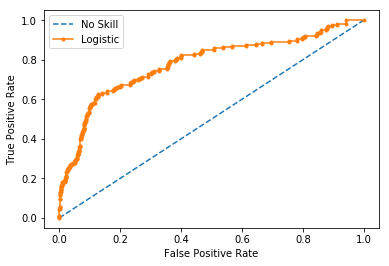

In [51]:
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

In [52]:
print(lr_auc)
print(ns_auc)

0.7809891435464414
0.5


In [53]:
print(f1_score(y_test, predictions, average="macro"))
print(precision_score(y_test, predictions, average="macro"))
print(recall_score(y_test, predictions, average="macro"))   

0.6302226539151226
0.6428766955384867
0.6205255902119593


In [54]:
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(LogisticRegression, k='all').fit(X_train,y_train)
# x_new = selector.transform(X) # not needed to get the sc?ore
scores = selector.scores_

In [55]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.93      0.94      0.94      1658
        True       0.36      0.30      0.32       175

   micro avg       0.88      0.88      0.88      1833
   macro avg       0.64      0.62      0.63      1833
weighted avg       0.87      0.88      0.88      1833



In [56]:
from sklearn.feature_selection import RFE
rfe = RFE(LogisticRegression(), 5)
rfe = rfe.fit(X_train, y_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True False  True]
[1 1 1 1 2 1]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [57]:
LR.coef_.T
x_cols

['rating_mean',
 'rating_count',
 'competition_first',
 'count_dropoffs',
 'passenger_count',
 'age']

In [58]:
feature_importance = pd.DataFrame()
feature_importance['Feature'] = x_cols
feature_importance['Feature Importance'] = LR.coef_.T

In [59]:
feature_importance

,Feature,Feature Importance
0,rating_mean,-4.133428e-05
1,rating_count,-1.144163e-05
2,competition_first,3.759759e-04
3,count_dropoffs,-1.982718e-07
4,passenger_count,5.626287e-08
5,age,-2.780276e-03


Random Forest Classifier

In [60]:
from sklearn.ensemble import RandomForestClassifier
RF= RandomForestClassifier()
RF.fit(X_train,y_train)
print("Accuracy: ",RF.score(X_test,y_test))

Accuracy:  0.9028914348063284


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [63]:
RF_predictions = RF.predict(X_test)
# print(np.sum(predictions==True))
RF_preds = y_test.to_frame()
RF_preds['prediction'] = RF_predictions
correct = RF_preds[(RF_preds['closed_label']==True)&(RF_preds['closed_label']==RF_preds['prediction'])].shape[0]
total = (RF_preds[RF_preds['closed_label']==True]).shape[0]

print(average_precision)
print(correct)
print(total)

0.3856396383109631
47
175


In [64]:
RF_lr_probs = RF.predict_proba(X_test)
# keep probabilities for the positive outcome only
RF_lr_probs = RF_lr_probs[:, 1]
RF_ns_probs = [0 for _ in range(len(y_test))]
RF_ns_auc = roc_auc_score(y_test, RF_ns_probs)
RF_lr_auc = roc_auc_score(y_test, RF_lr_probs)
print('No Skill: ROC AUC=%.3f' % (RF_ns_auc))
print('Logistic: ROC AUC=%.3f' % (RF_lr_auc))
RF_ns_fpr, RF_ns_tpr, _ = roc_curve(y_test, RF_ns_probs)
RF_lr_fpr, RF_lr_tpr, _ = roc_curve(y_test, RF_lr_probs)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.763


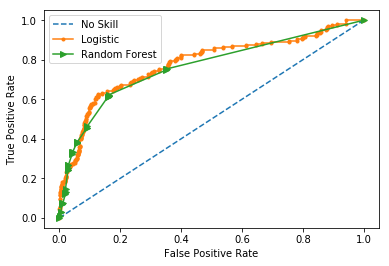

In [66]:
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(RF_lr_fpr, RF_lr_tpr, marker='>', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

Neural Network

In [88]:
from sklearn.naive_bayes import GaussianNB
NN= GaussianNB()
NN.fit(X_train,y_train)
print("Accuracy: ",NN.score(X_test,y_test))

Accuracy:  0.8968903436988543


In [89]:
NN_predictions = NN.predict(X_test)
print(np.sum(NN_predictions==True))
NN_preds = y_test.to_frame()
NN_preds['prediction'] = NN_predictions
correct = NN_preds[(NN_preds['closed_label']==True)&(NN_preds['closed_label']==NN_preds['prediction'])].shape[0]
total = (NN_preds[NN_preds['closed_label']==True]).shape[0]

print(correct)
print(total)

20
3
175


In [90]:
NN_lr_probs = NN.predict_proba(X_test)
# keep probabilities for the positive outcome only
NN_lr_probs = NN_lr_probs[:, 1]
NN_ns_probs = [0 for _ in range(len(y_test))]
NN_ns_auc = roc_auc_score(y_test, NN_ns_probs)
NN_lr_auc = roc_auc_score(y_test, NN_lr_probs)
print('No Skill: ROC AUC=%.3f' % (NN_ns_auc))
print('Logistic: ROC AUC=%.3f' % (NN_lr_auc))
NN_ns_fpr, NN_ns_tpr, _ = roc_curve(y_test, NN_ns_probs)
NN_lr_fpr, NN_lr_tpr, _ = roc_curve(y_test, NN_lr_probs)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.691


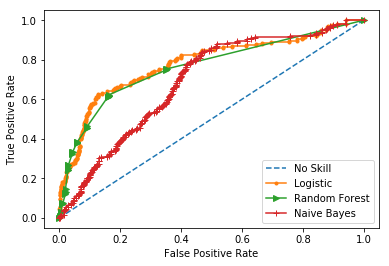

In [92]:
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(RF_lr_fpr, RF_lr_tpr, marker='>', label='Random Forest')
plt.plot(NN_lr_fpr, NN_lr_tpr, marker='+', label='Naive Bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()